In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [10]:
from quantum_tools.examples.symbolic_contexts import *
from quantum_tools.symmetries.workspace import *
from quantum_tools.visualization.sparse_vis import plot_matrix
from quantum_tools.config import *
from scipy import sparse
import numpy as np
from matplotlib import pyplot as plt

In [5]:
ABC_222_222

SymbolicContext(preinjectable_sets=[[['A2'], ['B2'], ['C2']], [['B2'], ['A2', 'C1']], [['C2'], ['A1', 'B2']], [['A2'], ['B1', 'C2']], [['A1', 'B1', 'C1']]], outcomes=[2, 2, 2, 2, 2, 2])

In [6]:
row_sum, A, col_sum, contracted_A = get_contraction_elements(ABC_222_222)

40 64
ShiftedBase(shift=0, base=(32, 16, 8, 4, 2, 1))
ShiftedBase(shift=0, base=(0, 4, 0, 2, 0, 1))
ShiftedBase(shift=8, base=(0, 4, 0, 2, 1, 0))
ShiftedBase(shift=16, base=(4, 0, 0, 2, 0, 1))
ShiftedBase(shift=24, base=(0, 4, 2, 0, 0, 1))
ShiftedBase(shift=32, base=(4, 0, 2, 0, 1, 0))
Found 14 row_orbits.
Found 20 col_orbits.


In [7]:
A

<40x64 sparse matrix of type '<class 'numpy.int16'>'
	with 320 stored elements in COOrdinate format>

<IPython.core.display.Javascript object>


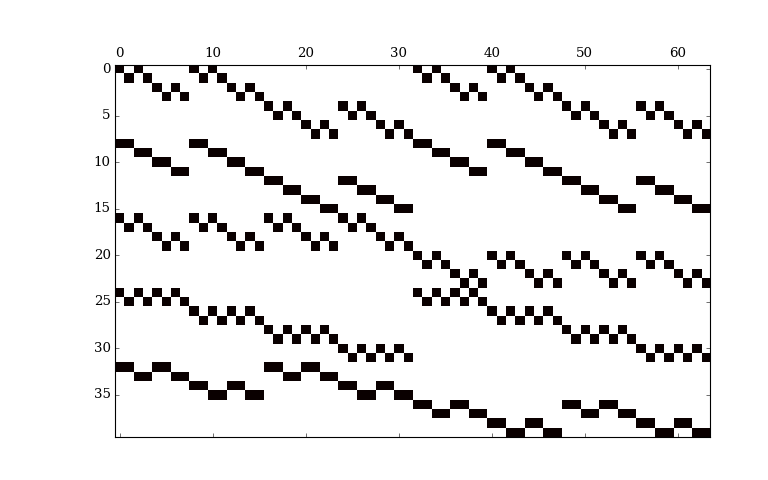

In [19]:
plt.matshow(A.todense()[:, :], cmap='hot_r')

<IPython.core.display.Javascript object>


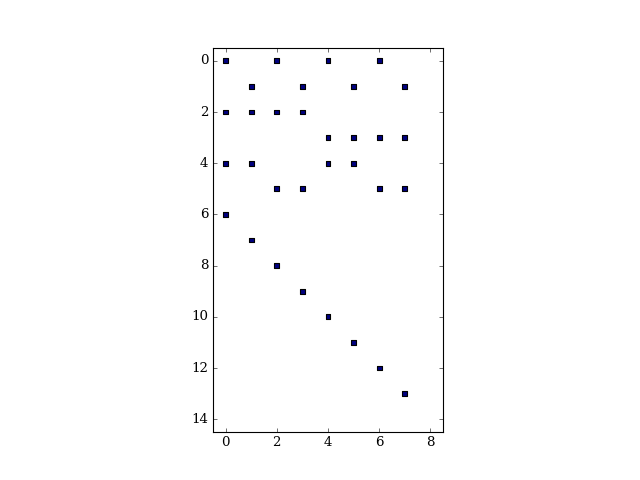

In [10]:
H = hyper_graph(A, 0)
plot_coo_matrix(H)

In [12]:
H_bool = H.astype(bool)
# x = sparse.csr_matrix(np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0]), dtype=bool)
# H.bitwise_or(x)

<IPython.core.display.Javascript object>


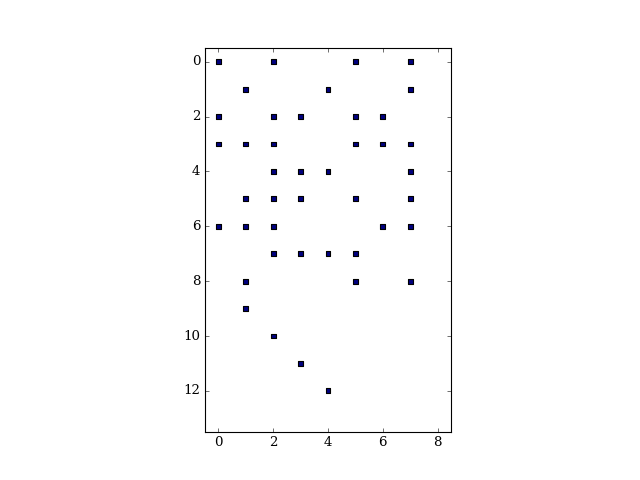

In [8]:
mediumH = sparse.csr_matrix(np.array([
            [1, 0, 1, 0, 0, 1, 0, 1],
            [0, 1, 0, 0, 1, 0, 0, 1],
            [1, 0, 1, 1, 0, 1, 1, 0],
            [1, 1, 1, 0, 0, 1, 1, 1],
            [0, 0, 1, 1, 1, 0, 0, 1],
            [0, 1, 1, 1, 0, 1, 0, 1],
            [1, 1, 1, 0, 0, 0, 1, 1],
            [0, 0, 1, 1, 1, 1, 0, 0],
            [0, 1, 0, 0, 0, 1, 0, 1],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
        ]))
smallH = sparse.csr_matrix(np.array([
            [1, 0, 1, 0, 1],
            [0, 1, 0, 0, 1],
            [1, 0, 1, 1, 0],
            [1, 1, 1, 0, 0],
            [0, 0, 1, 1, 1],
            [0, 1, 1, 1, 0],
        ]))
xsmallH = sparse.csr_matrix(np.array([
            [1, 0, 1],
            [0, 1, 1],
            [1, 1, 0],
        ]))
plot_coo_matrix(mediumH)

In [9]:
from functools import reduce
from operator import mul

def nzcfr(M, row):
    """ Non zero columns for a given row of a csr matrix """
    return M.indices[M.indptr[row]:M.indptr[row+1]]

def ptrflux(indptr):
    flux = indptr[1:] - indptr[:-1]
    return np.nonzero(flux)[0]

def sparse_any_eq(A, B):
    """
    SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
    """
    # If anything in the sparse diff is false, then some of A and B are equal
    sparse_diff = A != B
    diff_len = reduce(mul, sparse_diff.shape, 1)
    
    if sparse_diff.nnz == diff_len:
        return False
    else:
        return True

def hyper_graph(A, ant):
    A_coo = sparse.coo_matrix(A)
    A_csr = sparse.csr_matrix(A)
    # A_csc = sparse.csc_matrix(A)
    # Take only columns that are extendable versions of the antescedant (ant)
    ext_ant = nzcfr(A_csr, ant)
    ext_A = A_csr[:, ext_ant]
    # Take only rows that would contribute
    row_entry_flux = ext_A.indptr[1:] - ext_A.indptr[:-1] # Finds where the row pointers change
    row_entry_flux[ant] = 0 # Make antecedant zero so it doesn't get selected
    H = ext_A[np.nonzero(row_entry_flux)[0], :]
    return H

In [12]:
import inspect

class VerboseLog():
    
    def __init__(self, on=False):
        self.on = on
        
    def log(self, *args):
        if self.on:
            curframe = inspect.currentframe()
            calframe = inspect.getouterframes(curframe, 2)
            caller_name = calframe[1][3]
            print('[{name}]:'.format(name=caller_name), *args)

In [58]:
EXP_DTYPE = 'int16' # Can't be bool. Scipy sparse arrays don't support boolean matrices well

class FoundTransversals():
    
    def __init__(self):
        self._raw = None
        self._raw_sum = None
        
    def __len__(self):
        if self._raw is None:
            return 0
        else:
            return self._raw.shape[1]
        
    def update(self, ft):
        ft = sparse.csc_matrix(ft)
        total_ft = len(ft.data) # All identity elements
        if self._raw is None:
            # start it off
            self._raw = sparse.csc_matrix(ft) 
            self._raw_sum = np.array([total_ft], dtype=EXP_DTYPE)
        else:
            # need to check against found transversals
            overlap = _overlap(self._raw, ft)
            if np.any(overlap == self._raw_sum): # there is a found transversal more minimal than ft
                return
            fts_to_keep = overlap != total_ft # Keep those that are not supersets of ft
            
            self._raw = sparse.hstack((self._raw[:, fts_to_keep], ft))
            self._raw_sum = np.append(self._raw_sum[fts_to_keep], total_ft)
    
    def minimal_present(self, ft):
        if self._raw is None:
            return False
        else:
            overlap = _overlap(self._raw, ft)
            return np.any(overlap == self._raw_sum) # There is a more minimal one present
            
    def __getitem__(self, slice):
        if self._raw is None:
            return None
        return self._raw[slice]
    
    def raw(self):
        return self._raw
    
def _overlap(a, b):
    return (a.T * b).toarray().ravel()
    
def is_minimal_present(t, ts):
    """ Determines if a more mimimal transversal than t is present in ts """
    if ts is None:
        return False
    overlap = _overlap(ts, t) # How much t overlaps with the elements of ts
    total_fs = _overlap(ts, get_full_transversal(t.shape[0])) # Sums over the columns
    any_minimal = np.any(overlap == total_fs)
    return any_minimal

def cernikov_filter(wts, fts=None):
    """ Remove any of the working transversals that are minimal versions of each other """
    wt_i = 0
    wts = sparse.csc_matrix(wts)
    vl.log('Filtering {0}...'.format(wts.shape[1]))
    if fts is not None:
        fts = sparse.csc_matrix(fts)
    
    while wt_i < wts.shape[1]:
        target_t = wts[:, wt_i]
        left_t = wts[:, :max(wt_i, 0)]
        right_t = wts[:, min(wt_i+1, wts.shape[1]):]
        
        assert(left_t.shape[1] + right_t.shape[1] + target_t.shape[1] == wts.shape[1]), "Left/Right split failed."
        
        left_right_t = sparse.hstack((left_t, right_t))
        if fts is not None:
            check_ts = sparse.hstack((left_right_t, fts))
        else:
            check_ts = left_right_t
        
        if is_minimal_present(target_t, check_ts):
            wts = left_right_t # The new wts to loop over
            # [logic] wt_i = wt_i # Don't increase
        else:
            # [logic] wts = wts # Keep target
            wt_i += 1
    vl.log('...down to {0}'.format(wts.shape[1]))
    return wts
            
class SearchStrat():
    pass
    
    depth   = 'depth'
    breadth = 'breadth'
        
def get_null_transveral(size):
    """
    size : number of nodes
    """
    return sparse.csc_matrix((size, 1), dtype=EXP_DTYPE)

_full_transversal_pool = {}
def get_full_transversal(size):
    """
    size : number of nodes
    """
    global _full_transversal_pool
    if size not in _full_transversal_pool:
        _full_transversal_pool[size] = sparse.csc_matrix(np_ones((size, 1)), dtype=EXP_DTYPE)
    return _full_transversal_pool[size]

_unit_completion_pool = {}
def get_unit_completion(size):
    """
    size : number of edges
    """
    global _unit_completion_pool
    if size not in _unit_completion_pool:
        _unit_completion_pool[size] = sparse.csr_matrix(np_ones(size), dtype=EXP_DTYPE)
    return _unit_completion_pool[size]

_numpy_ones_pool = {}
def np_ones(shape):
    """
    shape: The numpy of ones
    """
    global _numpy_ones_pool
    if shape not in _numpy_ones_pool:
        _numpy_ones_pool[shape] = np.ones(shape, dtype=EXP_DTYPE)
    return _numpy_ones_pool[shape]
        
def find_transversals(H, strat=SearchStrat.depth):
    H = sparse.csc_matrix(H) # Needed for the algorithm
    fts = FoundTransversals() # Empty found transversals
    num_nodes = H.shape[0]
    if strat == SearchStrat.depth:
        work_on_transversals_depth(H, get_null_transveral(num_nodes), fts)
    else:
        work_on_transversals_breadth(H, get_null_transveral(num_nodes), fts)
    return fts

def verify_completion(H, wt, fts):
    # Check if transversal is complete
    completion = transversal_completion(H, wt)
    vl.log('completion')
    vl.log(completion)
    vl.log('is_completion')
    vl.log(is_complete_transversal(completion))
    if is_complete_transversal(completion):
        fts.update(wt) # Update the list of transversals with the new found one
        return True, None
    return False, completion

def work_on_transversals_breadth(H, wts, fts, current_depth=0):
    """ Work on a particular transversal going breadth first """
    # Current depth
    vl.log('current_depth')
    vl.log(current_depth)
    
    # Nothing to work on
    if wts is None or wts.shape[1] == 0:
        vl.log('Finished: Nothing to branch to.')
        return
    
    next_wts_list = []
    for wt_i in range(wts.shape[1]):
        wt = wts[:, wt_i]
        # Check if transversal is complete
        is_complete, completion = verify_completion(H, wt, fts)
        if is_complete:
            fts.update(wt)
            continue
    
        # Otherwise, branch to nodes that can contribute
        for node in branch_to_nodes(H, wt, completion):
            next_wt = continue_transveral(wt, node)
            next_wts_list.append(next_wt)
    
    # Nothing valid to continue on
    if len(next_wts_list) == 0:
        vl.log('Finished: All branches complete.')
        return
    
    next_wts_mtrx = sparse.hstack(next_wts_list)
    
    # Filter out minimal copies
    next_wts = cernikov_filter(next_wts_mtrx, fts.raw()) # Will iterate over columns
    
    work_on_transversals_breadth(H, next_wts, fts, current_depth + 1)        

def work_on_transversals_depth(H, wt, fts, current_depth=0):
    """ Work on a particular transversal going depth first """
    # Current depth
    vl.log('current_depth')
    vl.log(current_depth)

    # Check if transversal is complete
    is_complete, completion = verify_completion(H, wt, fts)
    if is_complete:
        return
    
    # Otherwise, branch to nodes that can contribute
    for node in branch_to_nodes(H, wt, completion):
        next_wt = continue_transveral(wt, node)
        if fts.minimal_present(next_wt):
            # A more minimal transversal is present, just continue on
            continue
        work_on_transversals_depth(H, next_wt, fts, current_depth + 1)        
        
def is_complete_transversal(completion):
    """ Given a completion is it complete """
    # Completion is a row vector
    return completion.nnz == completion.shape[1] # No nonzero elements means completion
    
def transversal_completion(H, t):
    """ Tells me the edges that were hit already (and how many times) """
    return t.T * H

# def transversal_overlap(H, t):
#     """ Get the overlap between the edges of a transversal (completion) and the entire hypergraph """
#     return H * t.T

def continue_transveral(wt, node):
    """
    wt : working transversal
    node : node to be chosen 
    """
    new_indices = np.append(wt.indices, [node])
    new_indptr = np.copy(wt.indptr)
    new_indptr[1] = len(new_indices)
    
    new_data = np_ones(len(wt.data) + 1)
    
    wt_new = sparse.csc_matrix((new_data, new_indices, new_indptr), shape=wt.shape)
    
    vl.log('new_t')
    vl.log(wt_new)
    
    return wt_new
    
def get_missing_edges(H, wt, completion):
    completion.data.fill(1) # unitize
    missing_edges = get_unit_completion(H.shape[1]) - completion # find what edges are missing
    return missing_edges
    
def branch_to_edges(H, wt, completion):
    missing_edges = get_missing_edges(H, wt, completion) # Obtain the missing edge sparse list
    edges = missing_edges.indices
    if len(edges) != 0:
        yield edges[0] # Even if it's not sorted, take a missing edge

# def edge_vector(edge, size):
#     return sparse.csr_matrix((np.ones(1), np.array([edge]), np.array([0, 1])),  shape=(1, size))
        
def branch_to_nodes(H, wt, completion):
    """
    decide which nodes to branch to next
    """
    next_edges = branch_to_edges(H, wt, completion)
    H = sparse.csc_matrix(H) # Ensures the matrix is csc format (should already be)
    for edge in next_edges:
        node_indices_to_contribute = H[:, edge].indices
#         edge_v = edge_vector(edge, H.shape[1])
#         nodes_to_contribute = transversal_overlap(H, edge_v)
#         node_indices_to_contribute = ptrflux(nodes_to_contribute.indptr)
        for i in node_indices_to_contribute:
            if not wt[i, 0] > 0: # not already part of working transversal
                vl.log('Branching to node')
                vl.log(i)
                yield i


In [59]:
vl = VerboseLog(False)

In [60]:
fts = find_transversals(hyper_graph(A, 0), strat='depth')
print(fts.raw().toarray())
# print(fts._raw_sum)

[[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0]
 [0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1]
 [0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1]]


In [52]:
continue_transveral(get_null_transveral(6), 1)

<6x1 sparse matrix of type '<class 'numpy.int16'>'
	with 1 stored elements in Compressed Sparse Column format>

In [ ]:
H_0

In [138]:
H_0.shape

(14, 30)

In [61]:
vl = VerboseLog(False)
PROFILE_MIXIN(find_transversals, hyper_graph(A, 11), 'depth')

         1068582 function calls (1066491 primitive calls) in 1.543 seconds

   Ordered by: cumulative time
   List reduced from 136 to 27 due to restriction <0.2>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.543    1.543 <ipython-input-58-2a954eaf0ac2>:131(find_transversals)
    416/1    0.007    0.000    1.543    1.543 <ipython-input-58-2a954eaf0ac2>:190(work_on_transversals_depth)
11584/9908    0.082    0.000    0.864    0.000 /usr/lib/python3.4/site-packages/scipy/sparse/compressed.py:24(__init__)
     1259    0.009    0.000    0.699    0.001 <ipython-input-58-2a954eaf0ac2>:47(_overlap)
     1128    0.006    0.000    0.642    0.001 <ipython-input-58-2a954eaf0ac2>:32(minimal_present)
     1808    0.009    0.000    0.596    0.000 /usr/lib/python3.4/site-packages/scipy/sparse/base.py:292(__mul__)
     1808    0.036    0.000    0.575    0.000 /usr/lib/python3.4/site-packages/scipy/sparse/compressed.py:473(_mul_sparse_matrix)
 

In [10]:
# def min_col(v):
#     min_val = np.inf
#     min_i = None
#     for i in range(v.shape[0]):
#         v_i = v.data[v.indptr[i]:v.indptr[i+1]]
#         if len(v_i) == 0: # No entries
#             val_v_i = 0
#         else:
#             val_v_i = v_i[0]
#         if val_v_i < min_val:
#             min_val = val_v_i
#             min_i = i
#     return min_i, min_val

# def max_col(v):
#     max_val = -np.inf
#     max_i = None
#     for i in range(v.shape[0]):
#         v_i = v.data[v.indptr[i]:v.indptr[i+1]]
#         if len(v_i) == 0: # No entries
#             val_v_i = 0
#         else:
#             val_v_i = v_i[0]
#         if val_v_i > max_val:
#             max_val = val_v_i
#             max_i = i
#     return max_i, max_val

In [11]:
# def compressed_sparse_stack(blocks, axis):
#     """
#     Stacking fast path for CSR/CSC matrices
#     (i) vstack for CSR, (ii) hstack for CSC.
#     """
#     print('blocks')
#     print(blocks)
#     other_axis = 1 if axis == 0 else 0
#     data = np.concatenate([b.data for b in blocks])
#     indices = np.concatenate([b.indices for b in blocks])
#     indptr = []
#     last_indptr = 0
#     constant_dim = blocks[0].shape[other_axis]
#     sum_dim = 0
#     print(constant_dim)
#     for b in blocks:
#         print(b.toarray())
#         print(b.shape[other_axis])
#         if b.shape[other_axis] != constant_dim:
#             raise ValueError('incompatible dimensions for axis %d' % other_axis)
#         sum_dim += b.shape[axis]
#         indptr.append(b.indptr[:-1] + last_indptr)
#         last_indptr += b.indptr[-1]
#     indptr.append([last_indptr])
#     indptr = np.concatenate(indptr)
#     if axis == 0:
#         return sparse.csr_matrix((data, indices, indptr), shape=(sum_dim, constant_dim))
#     else:
#         return sparse.csc_matrix((data, indices, indptr), shape=(constant_dim, sum_dim))
    
# def sparse_hstack(blocks):
#     return compressed_sparse_stack(blocks, 1)

# def sparse_vstack(blocks):
#     return compressed_sparse_stack(blocks, 0)